# Import all neccessary files

In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

%matplotlib inline

# Load and download files from dataset

In [2]:
train_audio_path = 'train/audio/'
filename = '/yes/0a7c2a8d_nohash_0.wav'
samples, sample_rate = librosa.load(str(train_audio_path)+filename) #downloads training audio files

# Code to create a spectogram of the audio file

In [3]:
def log_specgram(audio, sample_rate, window_size=20, #defines a function that calculates spectrogram
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

# Code to display wave and spectogram

Text(0.5, 0, 'Seconds')

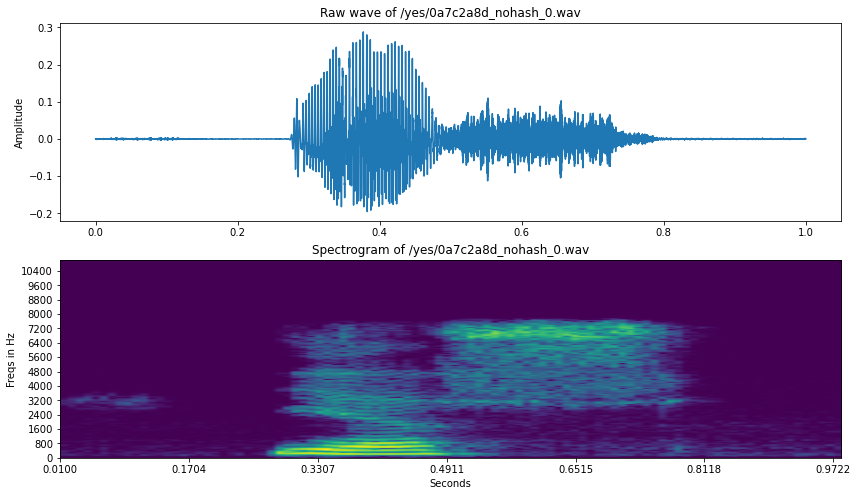

In [4]:
freqs, times, spectrogram = log_specgram(samples, sample_rate) #plots spectrogram and display spectrogram

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [5]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std

# Calculate mel power spectogram

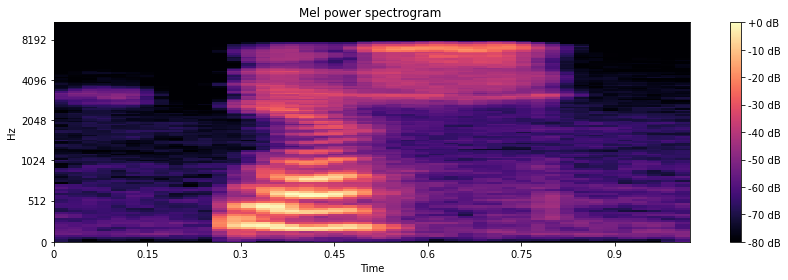

In [6]:
# From this tutorial
# https://github.com/librosa/librosa/blob/master/examples/LibROSA%20demo.ipynb
S = librosa.feature.melspectrogram(samples, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

# Calculate MFCC - Mel Frequency Cepstral Coefficient (Helps see the shape of the sounds)

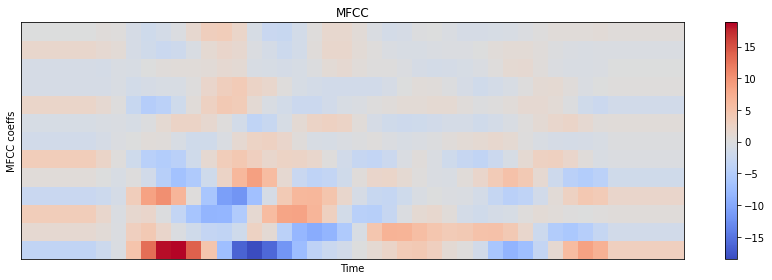

In [7]:
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

# Build and view 3D spectogram of audio file

In [8]:
data = [go.Surface(x=times, y=freqs, z=spectrogram.T)]
layout = go.Layout(
title='Specgtrogram of "yes" in 3d',
scene = dict(
yaxis = dict(title='Frequncy', range=[freqs.min(),freqs.max()]),
xaxis = dict(title='Time', range=[times.min(),times.max()],),
zaxis = dict(title='Log amplitude'),
),
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)

# Remove silence from audio files

In [9]:
ipd.Audio(samples, rate=sample_rate) #removes silences from aduio files to increase training times

In [10]:
samples_cut = samples[4000:13000]
ipd.Audio(samples_cut, rate=sample_rate)

# Split wave and spectogram to guess alignment of 'y' 'e' 's' graphems

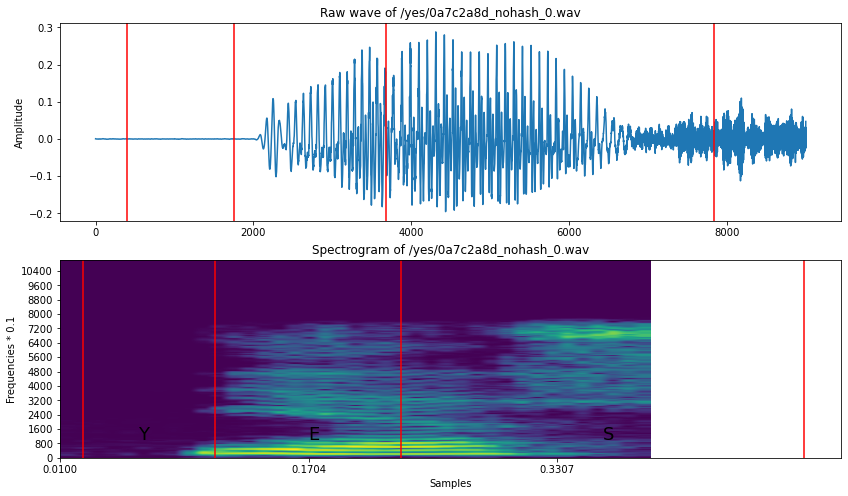

In [11]:
freqs, times, spectrogram_cut = log_specgram(samples_cut, sample_rate) #points out the silence in the audio file

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(samples_cut)

ax2 = fig.add_subplot(212)
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Frequencies * 0.1')
ax2.set_xlabel('Samples')
ax2.imshow(spectrogram_cut.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.text(0.06, 1000, 'Y', fontsize=18)
ax2.text(0.17, 1000, 'E', fontsize=18)
ax2.text(0.36, 1000, 'S', fontsize=18)

xcoords = [0.025, 0.11, 0.23, 0.49]
for xc in xcoords:
    ax1.axvline(x=xc*16000, c='r')
    ax2.axvline(x=xc, c='r')

# Calculate FFT (Fast Fourier Transform)- Reduces dimensionality of the audio by resampling frequencies to around 8000 Hz

In [12]:
def custom_fft(y, fs): #the original audio file produces sound at a frequency of 1600Hz, which doesn't sound natural so we resample the frequencies
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0/N * np.abs(yf[0:N//2])  # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

In [13]:
filename = '/happy/0b09edd3_nohash_0.wav'
new_sample_rate = 8000

sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
resampled = signal.resample(samples, int(new_sample_rate/sample_rate * samples.shape[0]))

# FFT Before and After

In [14]:
ipd.Audio(samples, rate=sample_rate) #before

In [15]:
ipd.Audio(resampled, rate=new_sample_rate) #after

# Visualization of FFT at different frequencies

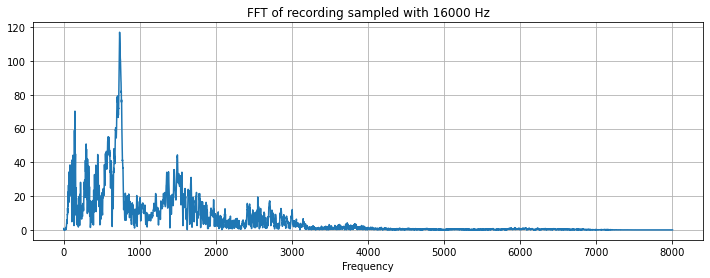

In [16]:
xf, vals = custom_fft(samples, sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show() #plots old audio recording "happy"

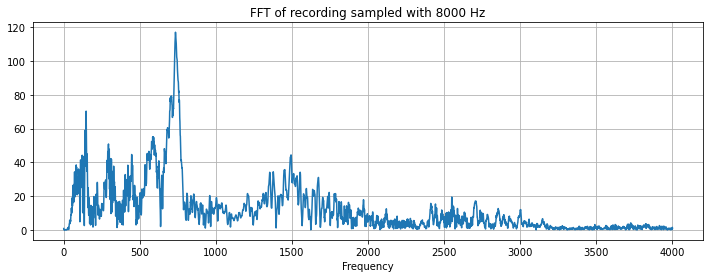

In [17]:
xf, vals = custom_fft(resampled, new_sample_rate)
plt.figure(figsize=(12, 4))
plt.title('FFT of recording sampled with ' + str(new_sample_rate) + ' Hz')
plt.plot(xf, vals)
plt.xlabel('Frequency')
plt.grid()
plt.show() #plots new audio recording 

In [18]:
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()
print('Number of labels: ' + str(len(dirs)))

Number of labels: 31


# Analysis of number of recordings per word in data

In [20]:
# Calculate
number_of_recordings = []
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    number_of_recordings.append(len(waves))

# Plot
data = [go.Histogram(x=dirs, y=number_of_recordings)]
trace = go.Bar(
    x=dirs,
    y=number_of_recordings,
    marker=dict(color = number_of_recordings, colorscale='viridis', showscale=True
    ),
)
layout = go.Layout(
    title='Number of recordings in given label',
    xaxis = dict(title='Words'),
    yaxis = dict(title='Number of recordings')
)
py.iplot(go.Figure(data=[trace], layout=layout)) #depicts a histogram of audio phrases

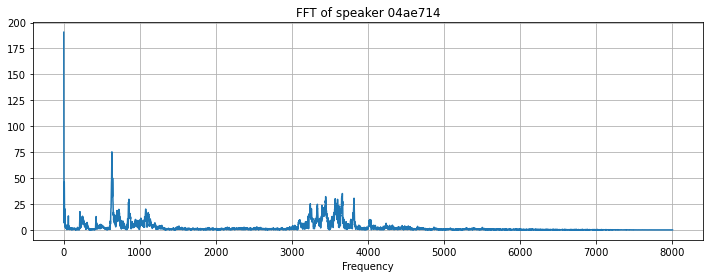

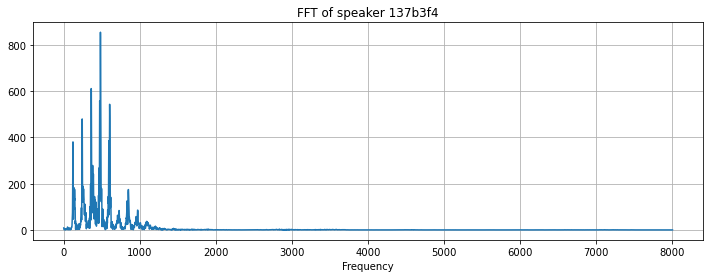

In [21]:
filenames = ['on/004ae714_nohash_0.wav', 'on/0137b3f4_nohash_0.wav']
for filename in filenames:
    sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
    xf, vals = custom_fft(samples, sample_rate)
    plt.figure(figsize=(12, 4))
    plt.title('FFT of speaker ' + filename[4:11])
    plt.plot(xf, vals)
    plt.xlabel('Frequency')
    plt.grid()
    plt.show() #splits audio files and differentiate testing from training

In [22]:
print('Speaker ' + filenames[0][4:11])
ipd.Audio(join(train_audio_path, filenames[0]))

Speaker 04ae714


In [23]:
print('Speaker ' + filenames[1][4:11])
ipd.Audio(join(train_audio_path, filenames[1]))

Speaker 137b3f4


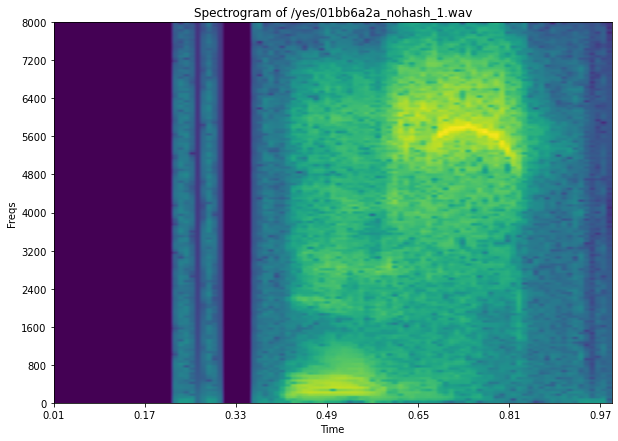

In [24]:
filename = '/yes/01bb6a2a_nohash_1.wav' #depicts a spectrogram
sample_rate, samples = wavfile.read(str(train_audio_path) + filename)
freqs, times, spectrogram = log_specgram(samples, sample_rate)

plt.figure(figsize=(10, 7))
plt.title('Spectrogram of ' + filename)
plt.ylabel('Freqs')
plt.xlabel('Time')
plt.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
plt.yticks(freqs[::16])
plt.xticks(times[::16])
plt.show()

In [25]:
num_of_shorter = 0 #searches for all audio files with a 1 sec duration
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] < sample_rate:
            num_of_shorter += 1
print('Number of recordings shorter than 1 second: ' + str(num_of_shorter))

/opt/conda/envs/speechrecognition/lib/python3.7/site-packages/ipykernel_launcher.py:5: WavFileWarning:

Chunk (non-data) not understood, skipping it.



Number of recordings shorter than 1 second: 6469


# Mean FFT and Spectogram throughout all the data

['down', 'go', 'left', 'no', 'off', 'on', 'right', 'stop', 'up', 'yes']


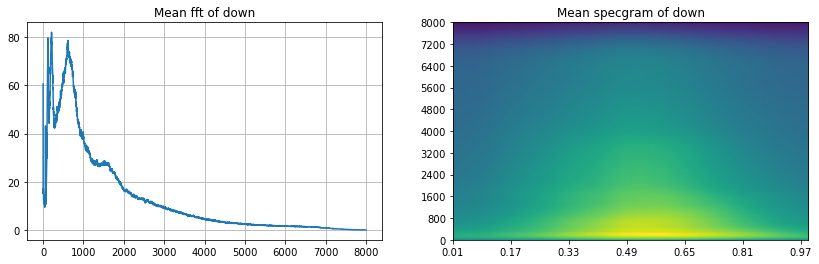

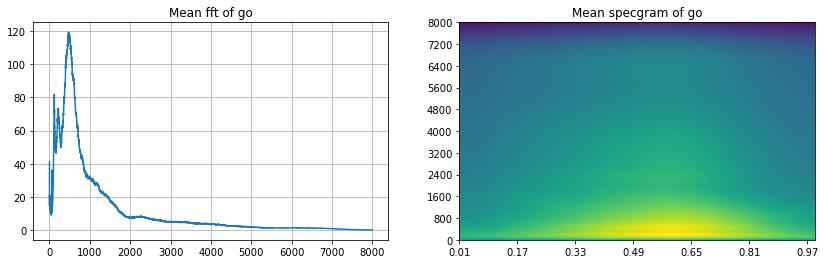

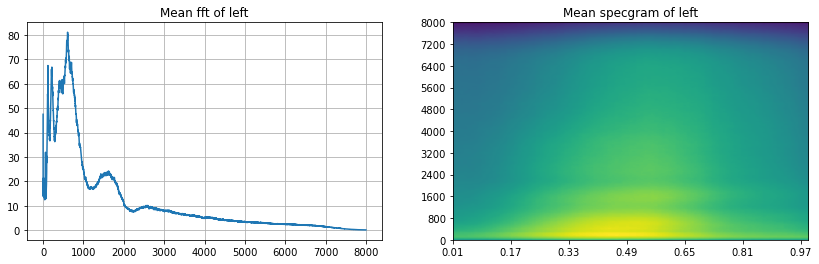

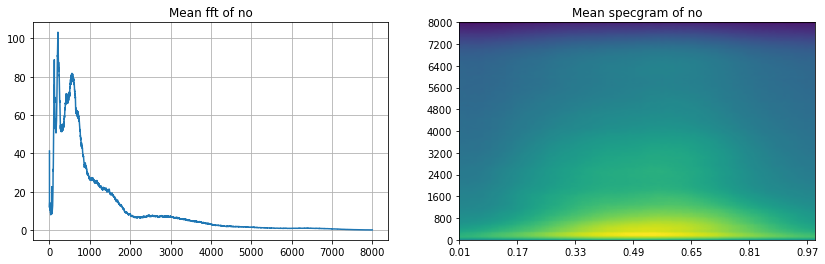

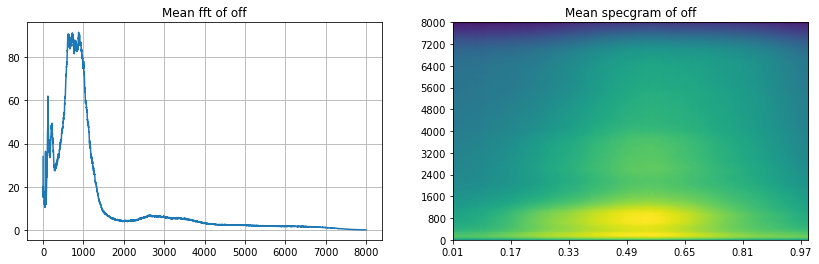

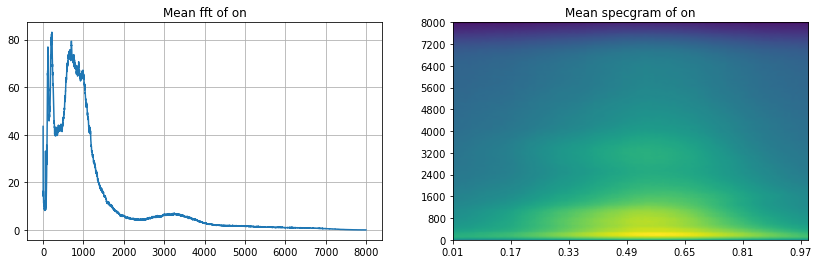

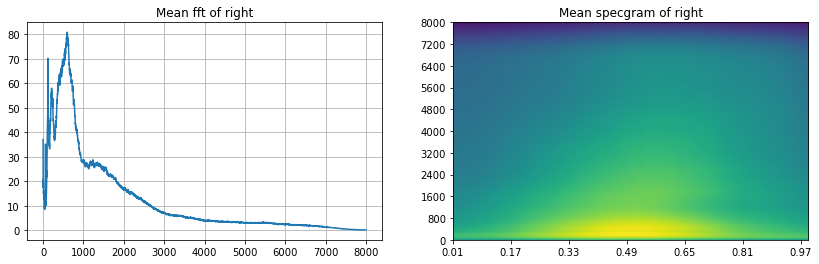

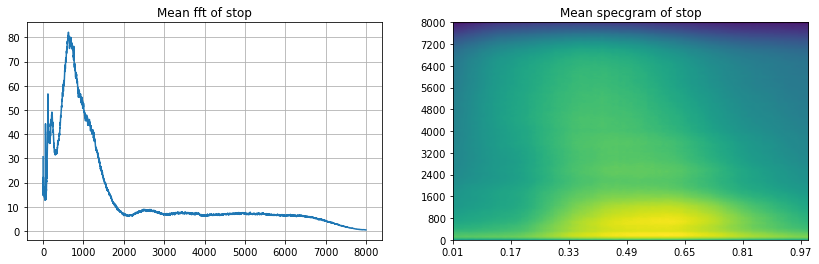

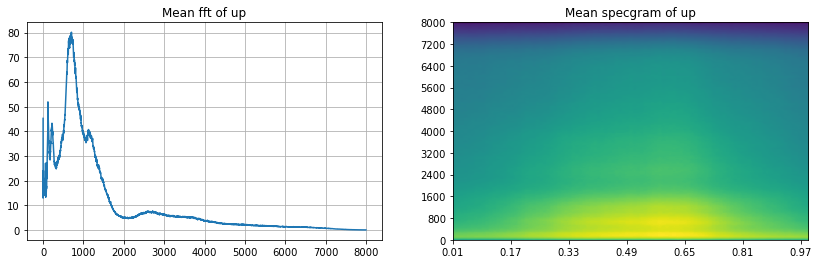

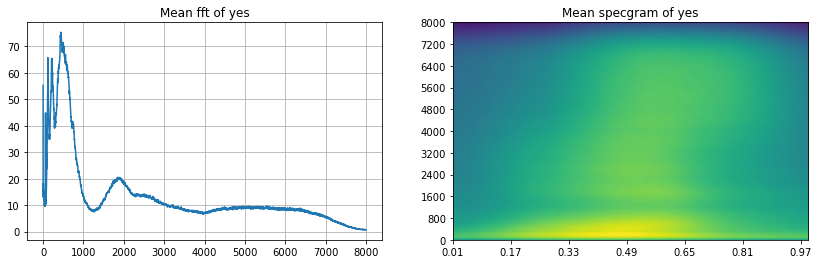

In [26]:
to_keep = 'yes no up down left right on off stop go'.split() #plots the mean of Fast Fourier Transform
dirs = [d for d in dirs if d in to_keep]

print(dirs)

for direct in dirs:
    vals_all = []
    spec_all = []

    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] != 16000:
            continue
        xf, vals = custom_fft(samples, 16000)
        vals_all.append(vals)
        freqs, times, spec = log_specgram(samples, 16000)
        spec_all.append(spec)

    plt.figure(figsize=(14, 4))
    plt.subplot(121)
    plt.title('Mean fft of ' + direct)
    plt.plot(np.mean(np.array(vals_all), axis=0))
    plt.grid()
    plt.subplot(122)
    plt.title('Mean specgram of ' + direct)
    plt.imshow(np.mean(np.array(spec_all), axis=0).T, aspect='auto', origin='lower', 
               extent=[times.min(), times.max(), freqs.min(), freqs.max()])
    plt.yticks(freqs[::16])
    plt.xticks(times[::16])
    plt.show()

# Code to visualize in violinplots

In [27]:
def violinplot_frequency(dirs, freq_ind): #measures the distribution of frequencies
    """ Plot violinplots for given words (waves in dirs) and frequency freq_ind
    from all frequencies freqs."""

    spec_all = []  # Contain spectrograms
    ind = 0
    for direct in dirs:
        spec_all.append([])

        waves = [f for f in os.listdir(join(train_audio_path, direct)) if
                 f.endswith('.wav')]
        for wav in waves[:100]:
            sample_rate, samples = wavfile.read(
                train_audio_path + direct + '/' + wav)
            freqs, times, spec = log_specgram(samples, sample_rate)
            spec_all[ind].extend(spec[:, freq_ind])
        ind += 1

    # Different lengths = different num of frames. Make number equal
    minimum = min([len(spec) for spec in spec_all])
    spec_all = np.array([spec[:minimum] for spec in spec_all])

    plt.figure(figsize=(13,7))
    plt.title('Frequency ' + str(freqs[freq_ind]) + ' Hz')
    plt.ylabel('Amount of frequency in a word')
    plt.xlabel('Words')
    sns.violinplot(data=pd.DataFrame(spec_all.T, columns=dirs))
    plt.show()

# Visualize audio in violin plots to study the frequency of each audio clip

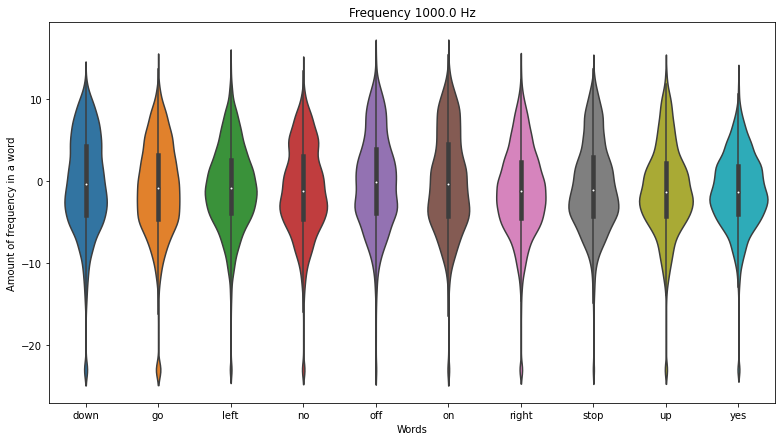

In [28]:
violinplot_frequency(dirs, 20)

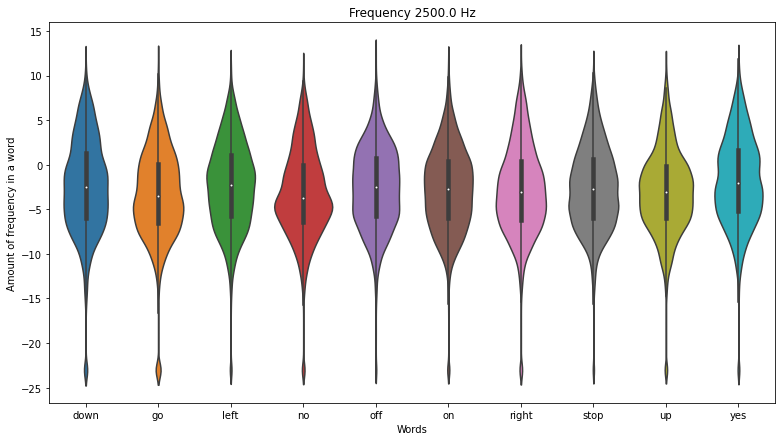

In [29]:
violinplot_frequency(dirs, 50)

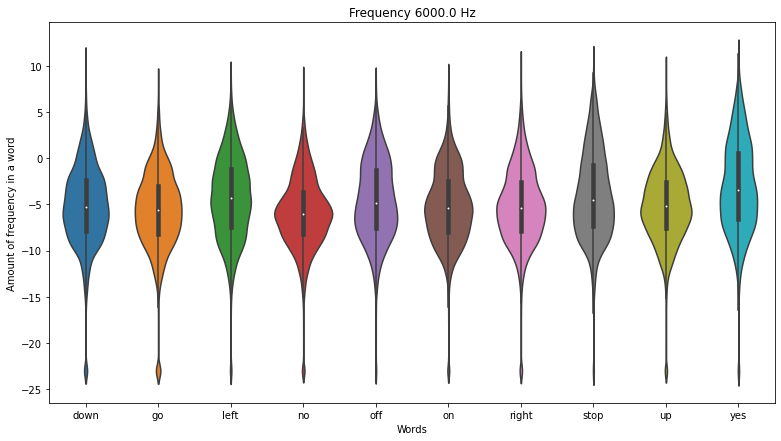

In [30]:
violinplot_frequency(dirs, 120)

# Code to detect anomalies

In [31]:
fft_all = []
names = []
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + direct + '/' + wav)
        if samples.shape[0] != sample_rate:
            samples = np.append(samples, np.zeros((sample_rate - samples.shape[0], )))
        x, val = custom_fft(samples, sample_rate)
        fft_all.append(val)
        names.append(direct + '/' + wav)

fft_all = np.array(fft_all)

# Normalization
fft_all = (fft_all - np.mean(fft_all, axis=0)) / np.std(fft_all, axis=0)

# Dim reduction
pca = PCA(n_components=3)
fft_all = pca.fit_transform(fft_all)

def interactive_3d_plot(data, names):
    scatt = go.Scatter3d(x=data[:, 0], y=data[:, 1], z=data[:, 2], mode='markers', text=names)
    data = go.Data([scatt])
    layout = go.Layout(title="Anomaly detection")
    figure = go.Figure(data=data, layout=layout)
    py.iplot(figure)
    
interactive_3d_plot(fft_all, names) #depicts a scatterplot to help distinguish any audio files that stand out from the rest

/opt/conda/envs/speechrecognition/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:40: DeprecationWarning:

plotly.graph_objs.Data is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.Scatter
  - plotly.graph_objs.Bar
  - plotly.graph_objs.Area
  - plotly.graph_objs.Histogram
  - etc.




In [32]:
print('Recording go/0487ba9b_nohash_0.wav')
ipd.Audio(join(train_audio_path, 'go/0487ba9b_nohash_0.wav')) #anomaly

Recording go/0487ba9b_nohash_0.wav


In [33]:
print('Recording yes/e4b02540_nohash_0.wav')
ipd.Audio(join(train_audio_path, 'yes/e4b02540_nohash_0.wav')) #anomaly

Recording yes/e4b02540_nohash_0.wav


In [34]:
print('Recording seven/e4b02540_nohash_0.wav')
ipd.Audio(join(train_audio_path, 'seven/b1114e4f_nohash_0.wav')) #anomaly

Recording seven/e4b02540_nohash_0.wav
